#Downloading Data

In [1]:
%%capture
!pip install ipython-autotime
%load_ext autotime

time: 596 µs (started: 2025-05-08 15:51:57 +00:00)


In [2]:
import pandas as pd
from google.colab import drive

time: 799 ms (started: 2025-05-08 15:51:57 +00:00)


In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.3 s (started: 2025-05-08 15:51:57 +00:00)


In [4]:
save_path = '/content/drive/My Drive/DS Final Project/Subject Classification/synthetic_enron_varied_unique.csv'
df = pd.read_csv(save_path)
df.head()

,Subject,Body,manual_label
0,Team alignment discussion,Just confirming that our regular meeting is st...,Meeting / Scheduling
1,Calendar conflict,Attaching a revised calendar invite for next w...,Meeting / Scheduling
2,Calendar conflict,"Due to scheduling conflicts, we'll need to shi...",Meeting / Scheduling
3,Calendar conflict,Attaching a revised calendar invite for next w...,Meeting / Scheduling
4,Meeting moved,"Due to scheduling conflicts, we'll need to shi...",Meeting / Scheduling


time: 116 ms (started: 2025-05-08 15:51:59 +00:00)


#Model

In [5]:
# Show number of unique topics
print("Number of unique topics:", df['manual_label'].nunique())

# Show topic counts
topic_counts = df['manual_label'].value_counts().sort_index()
print("\nEmails per topic:")
print(topic_counts)


Number of unique topics: 10

Emails per topic:
manual_label
Announcement / Info           91
Finance / Budget              89
HR / Personal                101
Legal / Compliance            92
Meeting / Scheduling          97
Other / Uncategorized         92
Project Update                95
Report / Summary              96
Request / Action Item         90
Support / Technical Issue     91
Name: count, dtype: int64
time: 16.4 ms (started: 2025-05-08 15:51:59 +00:00)


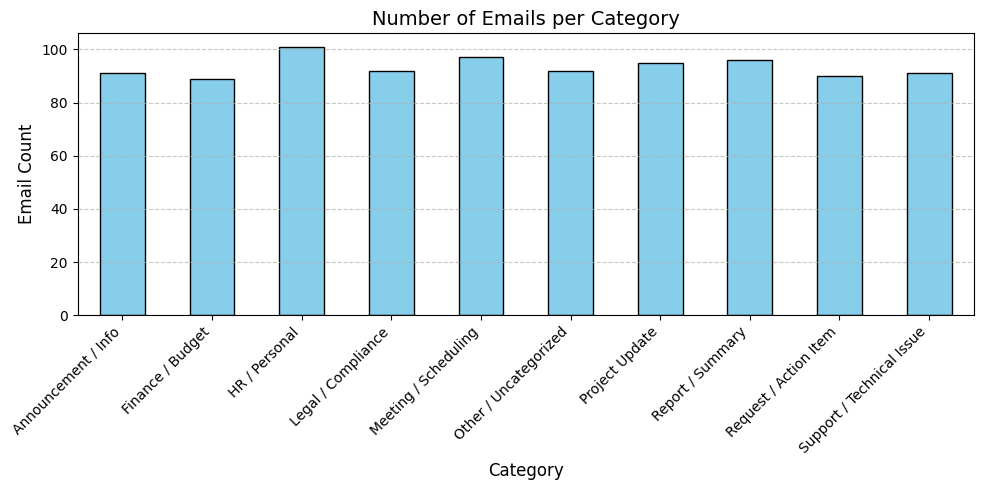

time: 579 ms (started: 2025-05-08 15:51:59 +00:00)


In [6]:
import matplotlib.pyplot as plt

# Count the number of emails per topic
topic_counts = df['manual_label'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 5))
topic_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Number of Emails per Category", fontsize=14)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Email Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##download

In [7]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

time: 36.2 s (started: 2025-05-08 15:52:00 +00:00)


In [8]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

time: 7.22 ms (started: 2025-05-08 15:52:36 +00:00)


##Encoding

In [9]:
df['text'] = df['Subject'] + ' ' + df['Body']

time: 4.57 ms (started: 2025-05-08 15:52:36 +00:00)


In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['manual_label'])

# Save this to decode predictions later
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{'Announcement / Info': np.int64(0), 'Finance / Budget': np.int64(1), 'HR / Personal': np.int64(2), 'Legal / Compliance': np.int64(3), 'Meeting / Scheduling': np.int64(4), 'Other / Uncategorized': np.int64(5), 'Project Update': np.int64(6), 'Report / Summary': np.int64(7), 'Request / Action Item': np.int64(8), 'Support / Technical Issue': np.int64(9)}
time: 2.51 ms (started: 2025-05-08 15:52:36 +00:00)


##Split

In [11]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42, stratify=df['label']
)

time: 25.8 ms (started: 2025-05-08 15:52:36 +00:00)


##Tokenize

In [12]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


time: 1.24 s (started: 2025-05-08 15:52:36 +00:00)


##Dataset Class

In [13]:
import torch
from torch.utils.data import Dataset

class EmailDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings  # tokenizer outputs
        self.labels = labels        # your numeric labels from LabelEncoder

    def __len__(self):
        return len(self.labels)  # how many samples in total

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }


time: 2.16 ms (started: 2025-05-08 15:52:37 +00:00)


In [14]:
train_dataset = EmailDataset(train_encodings, train_labels)
val_dataset = EmailDataset(val_encodings, val_labels)

time: 755 µs (started: 2025-05-08 15:52:37 +00:00)


##Bert

In [15]:
!pip install -U transformers

time: 3.42 s (started: 2025-05-08 15:30:03 +00:00)


In [15]:
from transformers import BertForSequenceClassification

num_labels = len(label_encoder.classes_)  # should be 10 for your case

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


time: 253 ms (started: 2025-05-08 15:52:37 +00:00)


In [20]:
from transformers import BertForSequenceClassification
import torch
from torch.optim import AdamW

# Define number of labels from your label encoder
num_labels = len(label_encoder.classes_)

# Load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Loss function (BERT already calculates loss internally)
loss_fn = torch.nn.CrossEntropyLoss()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


time: 814 ms (started: 2025-05-08 15:58:12 +00:00)


In [21]:
from torch.utils.data import DataLoader

# Use batch size = 16 as defined earlier
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


time: 1.45 ms (started: 2025-05-08 15:58:47 +00:00)


In [22]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(4):  # Set your number of epochs
    print(f"\n🔁 Epoch {epoch + 1}")

    # === TRAIN ===
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()

        preds = outputs.logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loss.backward()
        optimizer.step()

    train_acc = correct / total
    avg_train_loss = train_loss / len(train_loader)

    # === VALIDATION ===
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            preds = outputs.logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    avg_val_loss = val_loss / len(val_loader)

    print(f"✅ Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"🧪 Val   Loss: {avg_val_loss:.4f} | Val   Acc: {val_acc:.4f}")



🔁 Epoch 1


100%|██████████| 47/47 [06:52<00:00,  8.78s/it]


✅ Train Loss: 2.0111 | Train Acc: 0.3641
🧪 Val   Loss: 1.4021 | Val   Acc: 0.8342

🔁 Epoch 2


100%|██████████| 47/47 [06:43<00:00,  8.59s/it]


✅ Train Loss: 0.9436 | Train Acc: 0.9786
🧪 Val   Loss: 0.4437 | Val   Acc: 1.0000

🔁 Epoch 3


100%|██████████| 47/47 [06:44<00:00,  8.60s/it]


✅ Train Loss: 0.3155 | Train Acc: 1.0000
🧪 Val   Loss: 0.1525 | Val   Acc: 1.0000

🔁 Epoch 4


100%|██████████| 47/47 [06:59<00:00,  8.92s/it]


✅ Train Loss: 0.1351 | Train Acc: 1.0000
🧪 Val   Loss: 0.0788 | Val   Acc: 1.0000
time: 29min 25s (started: 2025-05-08 16:00:45 +00:00)


##Metrics

In [24]:
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = outputs.logits.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

time: 32.9 s (started: 2025-05-08 16:30:28 +00:00)


In [25]:
from sklearn.metrics import classification_report

# Decode back to label names
target_names = label_encoder.inverse_transform(sorted(set(all_labels)))

print(classification_report(all_labels, all_preds, target_names=target_names))

                           precision    recall  f1-score   support

      Announcement / Info       1.00      1.00      1.00        18
         Finance / Budget       1.00      1.00      1.00        18
            HR / Personal       1.00      1.00      1.00        20
       Legal / Compliance       1.00      1.00      1.00        18
     Meeting / Scheduling       1.00      1.00      1.00        20
    Other / Uncategorized       1.00      1.00      1.00        19
           Project Update       1.00      1.00      1.00        19
         Report / Summary       1.00      1.00      1.00        19
    Request / Action Item       1.00      1.00      1.00        18
Support / Technical Issue       1.00      1.00      1.00        18

                 accuracy                           1.00       187
                macro avg       1.00      1.00      1.00       187
             weighted avg       1.00      1.00      1.00       187

time: 23.9 ms (started: 2025-05-08 16:31:01 +00:00)


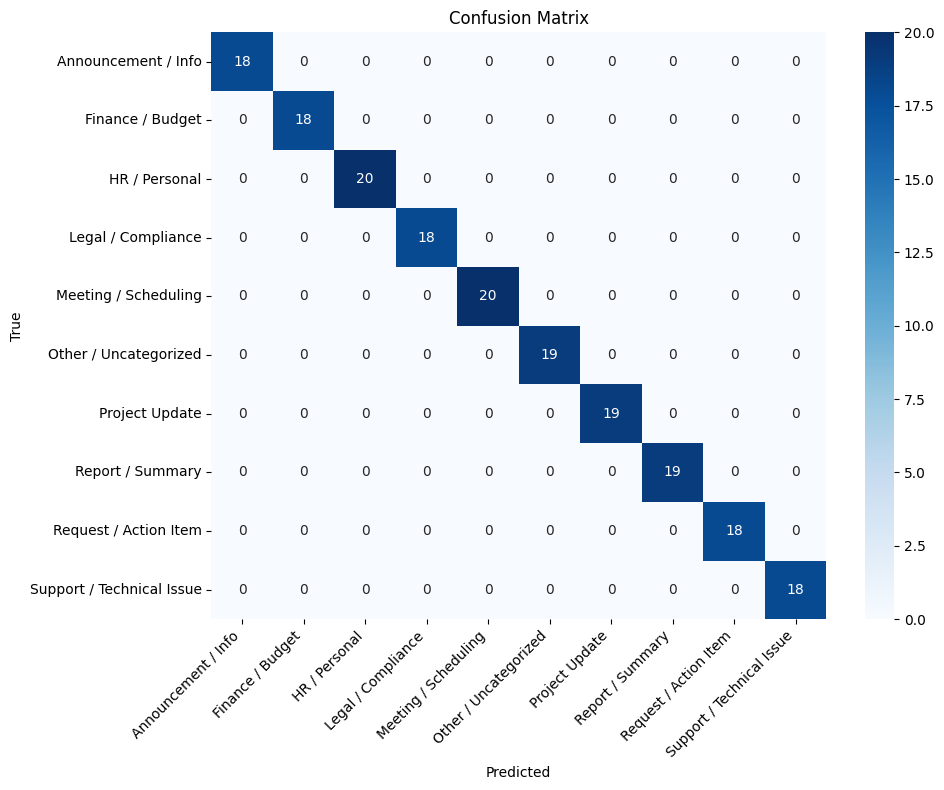

time: 770 ms (started: 2025-05-08 16:31:01 +00:00)


In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()